<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/UTS/MLP/DeepLearning_UTS_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Loading dataset...

Dataset Overview:
Number of samples: 515344
Number of features: 91

First 5 rows:
   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26.02574   

   15.37344   1.1114

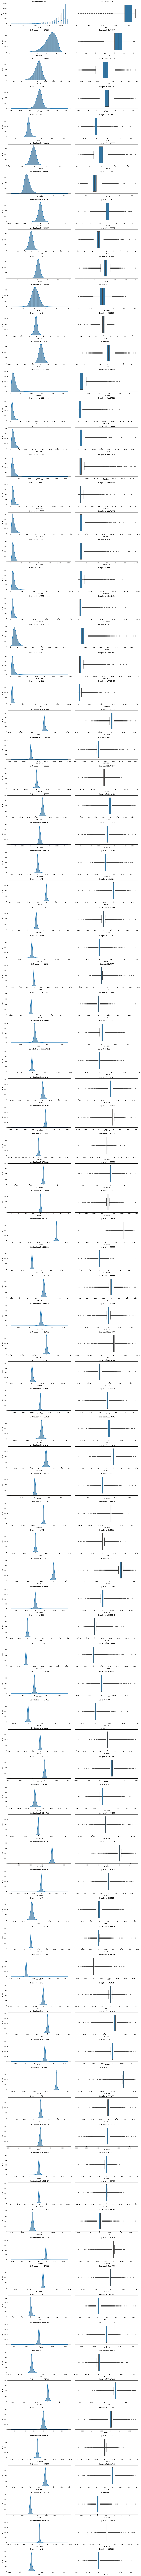


Categorical features: []

Correlation Matrix:


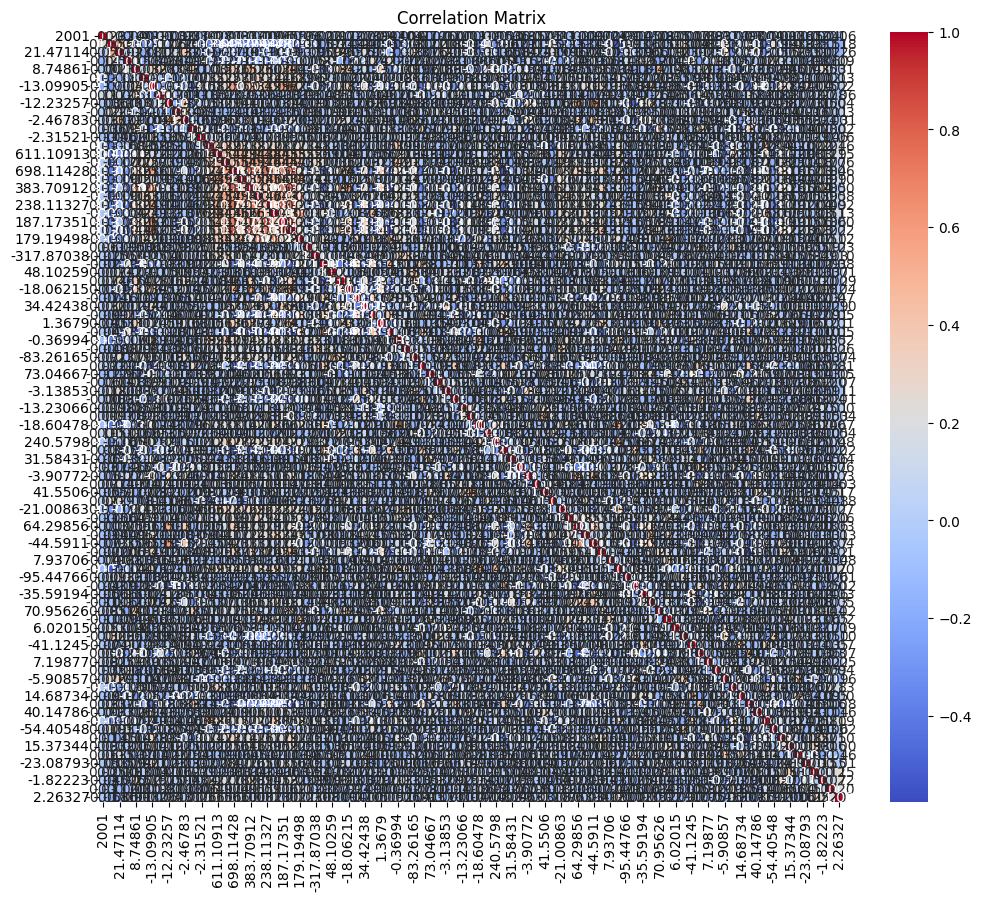

In [ ]:
def load_and_explore_data(file_path):
    """
    Load dataset and perform initial exploratory data analysis

    Args:
        file_path: Path to the CSV file

    Returns:
        DataFrame containing the loaded data
    """
    # Load the dataset
    print("Loading dataset...")
    df = pd.read_csv(file_path)

    # Display basic information
    print("\nDataset Overview:")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    # Display first few rows
    print("\nFirst 5 rows:")
    print(df.head())

    # Data types and non-null values
    print("\nData information:")
    print(df.info())

    # Statistical summary
    print("\nStatistical Summary:")
    print(df.describe().T)

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Visualize distributions of numerical features
    print("\nVisualizing numerical features distributions...")
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(num_cols) > 0:
        plt.figure(figsize=(15, len(num_cols)*3))
        for i, col in enumerate(num_cols, 1):
            plt.subplot(len(num_cols), 2, i*2-1)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')

            plt.subplot(len(num_cols), 2, i*2)
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

    # Identify categorical features
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"\nCategorical features: {cat_cols}")

    # Visualize categorical features if present
    if len(cat_cols) > 0:
        plt.figure(figsize=(15, len(cat_cols)*4))
        for i, col in enumerate(cat_cols, 1):
            plt.subplot(len(cat_cols), 1, i)
            counts = df[col].value_counts()
            sns.barplot(x=counts.index, y=counts.values)
            plt.title(f'Counts of {col}')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Correlation matrix for numerical features
    if len(num_cols) > 1:
        print("\nCorrelation Matrix:")
        plt.figure(figsize=(12, 10))
        corr_matrix = df[num_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.show()

    return df

# Load the dataset
df = load_and_explore_data('/content/drive/MyDrive/Colab Notebooks/RegresiUTSTelkom.csv')

In [ ]:
def clean_data(df):
    """
    Clean the dataset by handling missing values and outliers

    Args:
        df: Input DataFrame

    Returns:
        Cleaned DataFrame
    """
    print("Starting data cleaning process...")
    cleaned_df = df.copy()

    # Identify numerical and categorical columns
    num_cols = cleaned_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = cleaned_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Handle missing values
    if cleaned_df.isnull().sum().sum() > 0:
        print("Handling missing values...")

        # For numerical columns: fill with median (more robust to outliers than mean)
        for col in num_cols:
            if cleaned_df[col].isnull().sum() > 0:
                median_val = cleaned_df[col].median()
                cleaned_df[col].fillna(median_val, inplace=True)
                print(f"  - Filled missing values in '{col}' with median ({median_val:.2f})")

        # For categorical columns: fill with mode (most frequent value)
        for col in cat_cols:
            if cleaned_df[col].isnull().sum() > 0:
                mode_val = cleaned_df[col].mode()[0]
                cleaned_df[col].fillna(mode_val, inplace=True)
                print(f"  - Filled missing values in '{col}' with mode ('{mode_val}')")

    # Handle outliers in numerical columns using IQR method
    print("\nHandling outliers using IQR method...")
    for col in num_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = ((cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)).sum()

        if outliers > 0:
            print(f"  - Detected {outliers} outliers in '{col}'")

            # Cap the outliers instead of removing them
            cleaned_df[col] = cleaned_df[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"    - Capped outliers to range [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Drop duplicate rows if any
    duplicates = cleaned_df.duplicated().sum()
    if duplicates > 0:
        print(f"\nRemoving {duplicates} duplicate rows...")
        cleaned_df.drop_duplicates(inplace=True)

    print("\nData cleaning completed.")
    return cleaned_df

# Clean the dataset
cleaned_df = clean_data(df)

Starting data cleaning process...

Handling outliers using IQR method...
  - Detected 29703 outliers in '2001'
    - Capped outliers to range [1976.00, 2024.00]
  - Detected 10627 outliers in '49.94357'
    - Capped outliers to range [28.14, 59.65]
  - Detected 14647 outliers in '21.47114'
    - Capped outliers to range [-119.34, 129.40]
  - Detected 15630 outliers in '73.0775'
    - Capped outliers to range [-73.30, 91.61]
  - Detected 22688 outliers in '8.74861'
    - Capped outliers to range [-34.40, 34.70]
  - Detected 10454 outliers in '-17.40628'
    - Capped outliers to range [-63.28, 50.35]
  - Detected 11994 outliers in '-13.09905'
    - Capped outliers to range [-42.52, 21.69]
  - Detected 13904 outliers in '-25.01202'
    - Capped outliers to range [-36.71, 32.44]
  - Detected 14544 outliers in '-12.23257'
    - Capped outliers to range [-20.54, 16.99]
  - Detected 15398 outliers in '7.83089'
    - Capped outliers to range [-20.68, 28.35]
  - Detected 6238 outliers in '-2.46

In [ ]:
def engineer_features(df, target_column):
    """
    Perform feature engineering including scaling, encoding, and feature creation
    """
    print("Starting feature engineering process...")
    processed_df = df.copy()

    # Separate target variable
    if target_column not in processed_df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")

    X = processed_df.drop(columns=[target_column])
    y = processed_df[target_column]

    # Identify numerical and categorical columns
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Numerical features: {len(num_cols)}")
    print(f"Categorical features: {len(cat_cols)}")

    # Initialize preprocessing components
    preprocessor = {
        'num_cols': num_cols,
        'cat_cols': cat_cols
    }

    # 1. Feature Scaling for numerical features
    if len(num_cols) > 0:
        print("\nScaling numerical features...")
        scaler = StandardScaler()
        X_numeric = pd.DataFrame(
            scaler.fit_transform(X[num_cols]),
            columns=num_cols,
            index=X.index
        )
        preprocessor['scaler'] = scaler

        # Replace original numerical columns with scaled versions
        for col in num_cols:
            X[col] = X_numeric[col]

        print(f"  - Applied StandardScaler to {len(num_cols)} numerical features")

    # 2. Encoding categorical features
    if len(cat_cols) > 0:
        print("\nEncoding categorical features...")

        for col in cat_cols:
            unique_values = X[col].nunique()

            if unique_values <= 10:  # Threshold for one-hot encoding
                print(f"  - Applying One-Hot Encoding to '{col}' ({unique_values} unique values)")
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoded = encoder.fit_transform(X[[col]])

                # Create column names for encoded features
                encoded_cols = [f"{col}_{val}" for val in encoder.categories_[0][1:]]

                # Store encoder
                preprocessor[f'ohe_{col}'] = encoder

                # Create DataFrame with encoded values
                encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=X.index)
                X = pd.concat([X, encoded_df], axis=1)
                X.drop(columns=[col], inplace=True)
            else:
                print(f"  - Applying Label Encoding to '{col}' ({unique_values} unique values)")
                encoder = LabelEncoder()
                X[col] = encoder.fit_transform(X[col])

                # Store encoder
                preprocessor[f'le_{col}'] = encoder

    # 3. Feature Creation
    print("\nCreating new features...")

    # Based on the dataset name suggesting it's a regression task, let's create some polynomial features
    # This is especially useful if there might be non-linear relationships

    # Select a few numerical features with highest correlation to target for polynomial features
    if len(num_cols) >= 2:
        # Calculate correlations with target
        corr_with_target = {}
        for col in num_cols:
            if col in X.columns:  # Check if column still exists after previous processing
                corr_with_target[col] = abs(np.corrcoef(X[col], y)[0, 1])

        # Sort by correlation
        sorted_corrs = sorted(corr_with_target.items(), key=lambda x: x[1], reverse=True)

        # Select top 2 features for polynomial transformations
        top_features = [item[0] for item in sorted_corrs[:2]]

        if len(top_features) >= 2:
            # Create interaction term
            col1, col2 = top_features[0], top_features[1]
            X[f'{col1}_times_{col2}'] = X[col1] * X[col2]
            print(f"  - Created interaction feature: {col1}_times_{col2}")

            # Create squared terms
            X[f'{col1}_squared'] = X[col1] ** 2
            X[f'{col2}_squared'] = X[col2] ** 2
            print(f"  - Created polynomial features: {col1}_squared, {col2}_squared")

            # Create log transformation (handling potential negative values)
            for col in top_features:
                min_val = X[col].min()
                if min_val < 0:
                    X[f'log_{col}'] = np.log(X[col] - min_val + 1)
                else:
                    X[f'log_{col}'] = np.log(X[col] + 1)
                print(f"  - Created log feature: log_{col}")

    # 4. Feature Selection
    print("\nPerforming feature selection...")

    # Use SelectKBest to choose the most relevant features
    feature_count = X.shape[1]
    k = min(feature_count, 50)  # Select up to 50 features or all if fewer

    selector = SelectKBest(f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_indices].tolist()

    print(f"  - Selected {len(selected_features)} most relevant features")

    # Create final dataframe with selected features
    X_final = pd.DataFrame(X_selected, columns=selected_features, index=X.index)

    # Store selector in preprocessor
    preprocessor['selector'] = selector
    preprocessor['selected_features'] = selected_features

    print(f"\nFeature engineering completed. Final feature count: {X_final.shape[1]}")
    return X_final, y, preprocessor

# Perform feature engineering - uncomment to execute
target_column = '2001'  # The identified target column
X, y, preprocessor = engineer_features(cleaned_df, target_column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Starting feature engineering process...
Numerical features: 90
Categorical features: 0

Scaling numerical features...
  - Applied StandardScaler to 90 numerical features

Creating new features...
  - Created interaction feature: 49.94357_times_-13.09905
  - Created polynomial features: 49.94357_squared, -13.09905_squared
  - Created log feature: log_49.94357
  - Created log feature: log_-13.09905

Performing feature selection...
  - Selected 50 most relevant features

Feature engineering completed. Final feature count: 50


Building and training MLP model...

Menggunakan learning_rate=0.01, batch_size=32
Epoch 1/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 153242.1875 - mae: 285.7655 - val_loss: 17253.9512 - val_mae: 122.5886 - learning_rate: 0.0100
Epoch 2/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 87657.2344 - mae: 236.8836 - val_loss: 2238.4124 - val_mae: 44.0160 - learning_rate: 0.0100
Epoch 3/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 57592.4258 - mae: 191.1562 - val_loss: 662.6898 - val_mae: 22.2320 - learning_rate: 0.0100
Epoch 4/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 46918.5859 - mae: 172.7872 - val_loss: 512.4052 - val_mae: 19.5979 - learning_rate: 0.0100
Epoch 5/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 41106.9102 - mae: 161.3152 - val_loss: 220.0059 - val_mae: 13.4120 - learning_rate: 0.0100
Epoch 6/100
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 36757.6836 - mae: 151.7745 - val_loss: 525.1825 - val_mae: 21.

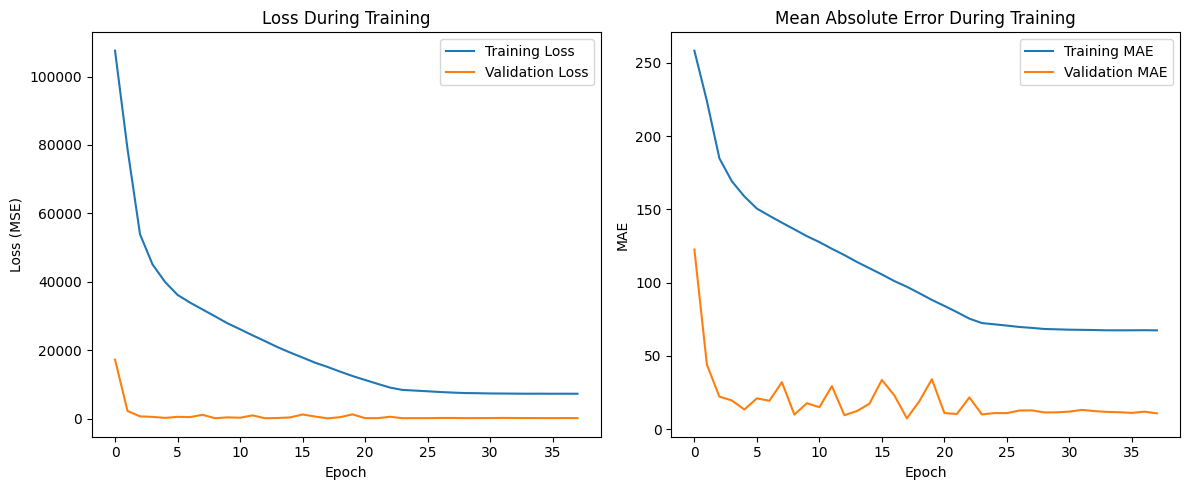


Test Loss (MSE): 88.8958
Test MAE: 7.4033


In [ ]:
def build_mlp_model(input_dim, learning_rate=0.001):
    """
    Build a Multilayer Perceptron (MLP) model with appropriate architecture
    """
    # Initialize model
    model = Sequential([
        # Input layer with appropriate regularization
        Dense(128, activation='relu', input_dim=input_dim,
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),

        # Hidden layers with decreasing sizes
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),

        # Output layer (linear activation for regression)
        Dense(1)
    ])

    # Compile model with Adam optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_and_tune_model(X_train, y_train, X_test, y_test):
    """
    Train the MLP model with fixed hyperparameters
    """
    print("Building and training MLP model...")

    # Define hyperparameters to tune
    learning_rates = 0.01
    batch_sizes = 32

    # Convert to numpy arrays if they're DataFrames
    if isinstance(X_train, pd.DataFrame):
        X_train_array = X_train.values
    else:
        X_train_array = X_train

    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values
    else:
        X_test_array = X_test

    if isinstance(y_train, pd.Series):
        y_train_array = y_train.values
    else:
        y_train_array = y_train

    if isinstance(y_test, pd.Series):
        y_test_array = y_test.values
    else:
        y_test_array = y_test

    # Create validation set
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_array, y_train_array, test_size=0.2, random_state=42
    )

    input_dim = X_train_array.shape[1]

    # Setup callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Build model with fixed hyperparameters
    print(f"\nMenggunakan learning_rate={learning_rates}, batch_size={batch_sizes}")
    model = build_mlp_model(input_dim=input_dim, learning_rate=learning_rates)

    # Train model
    history = model.fit(
        X_train_final, y_train_final,
        epochs=100,
        batch_size=batch_sizes,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save model parameters
    best_model = model
    best_history = history
    best_params = {'learning_rate': learning_rates, 'batch_size': batch_sizes}
    best_val_loss = min(history.history['val_loss'])

    print(f"\nParameter model: {best_params}")
    print(f"Validation loss: {best_val_loss:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error During Training')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate final model on test set
    test_loss, test_mae = best_model.evaluate(X_test_array, y_test_array, verbose=0)
    print(f"\nTest Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    return best_model, best_history, best_params

# Menjalankan pelatihan model
model, history, best_params = train_and_tune_model(X_train, y_train, X_test, y_test)

Melakukan evaluasi terhadap model regresi...
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Metrik Evaluasi Regresi:
Mean Squared Error (MSE): 88.8957
Root Mean Squared Error (RMSE): 9.4285
Mean Absolute Error (MAE): 7.4032
Koefisien Determinasi (R²): -0.0028
RMSE Ternormalisasi: 0.2694 (9.43/35.00)
MAE Ternormalisasi: 0.2115 (7.40/35.00)


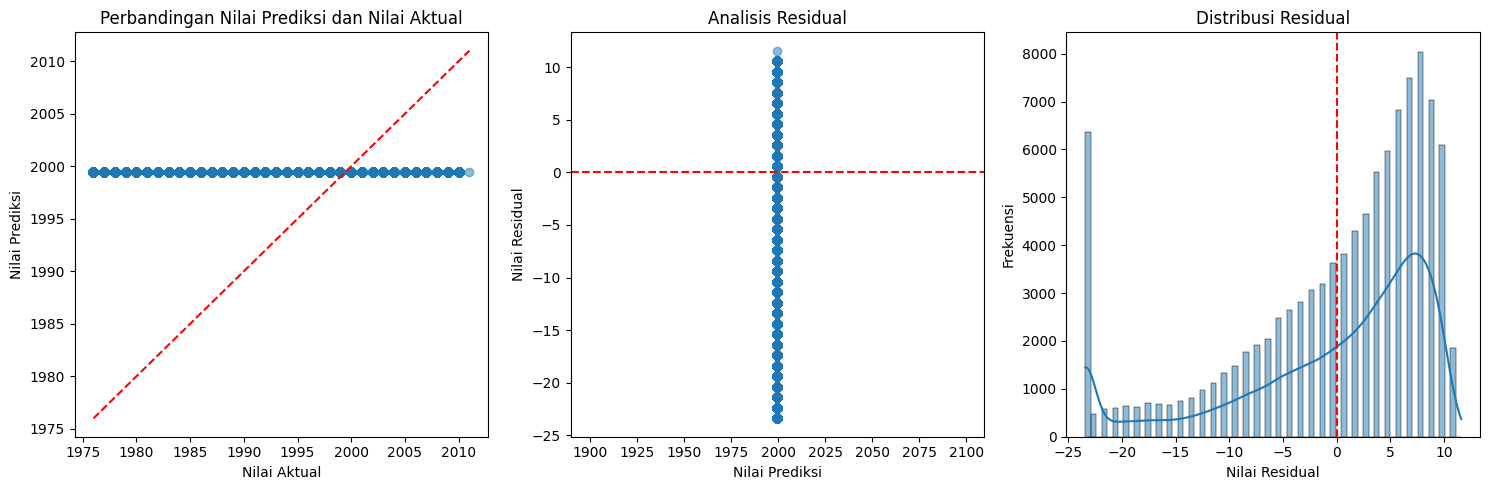


Interpretasi Metrik Evaluasi:
1. Nilai R² sebesar -0.0028 mengindikasikan kekuatan prediktif model yang kurang baik.
   - Hal ini menunjukkan bahwa model mampu menjelaskan -0.3% variasi pada variabel target.
2. RMSE ternormalisasi sebesar 0.2694 mengindikasikan akurasi prediksi yang cukup.
   - Rata-rata kesalahan prediksi adalah 26.9% dari rentang nilai variabel target.
3. Untuk tugas regresi spesifik ini:
   - Mengingat target adalah nilai tahunan (2001), RMSE merepresentasikan rata-rata kesalahan dalam prediksi
   - MAE mungkin lebih mudah diinterpretasikan karena merepresentasikan rata-rata selisih absolut antara nilai prediksi dan nilai aktual

Analisis Kepentingan Fitur:
Kepentingan fitur tidak dapat diekstraksi langsung dari jaringan saraf tanpa teknik tambahan.
Pertimbangkan untuk menggunakan permutation importance atau nilai SHAP untuk analisis kepentingan fitur.


In [ ]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Melakukan evaluasi komprehensif terhadap model regresi menggunakan berbagai metrik evaluasi
    """
    print("Melakukan evaluasi terhadap model regresi...")

    # Konversi ke array numpy jika diperlukan
    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values
    else:
        X_test_array = X_test

    if isinstance(y_test, pd.Series):
        y_test_array = y_test.values
    else:
        y_test_array = y_test

    # Membuat prediksi
    y_pred = model.predict(X_test_array).flatten()

    # Menghitung metrik-metrik evaluasi regresi
    mse = mean_squared_error(y_test_array, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_array, y_pred)
    r2 = r2_score(y_test_array, y_pred)

    # Menampilkan metrik evaluasi
    print("\nMetrik Evaluasi Regresi:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Koefisien Determinasi (R²): {r2:.4f}")

    # Menghitung metrik kesalahan ternormalisasi
    y_range = y_test_array.max() - y_test_array.min()
    normalized_rmse = rmse / y_range
    normalized_mae = mae / y_range

    print(f"RMSE Ternormalisasi: {normalized_rmse:.4f} ({rmse:.2f}/{y_range:.2f})")
    print(f"MAE Ternormalisasi: {normalized_mae:.4f} ({mae:.2f}/{y_range:.2f})")

    # Visualisasi hasil evaluasi
    plt.figure(figsize=(15, 5))

    # Visualisasi hubungan nilai prediksi dan nilai aktual
    plt.subplot(1, 3, 1)
    plt.scatter(y_test_array, y_pred, alpha=0.5)

    # Menambahkan garis prediksi sempurna
    min_val = min(min(y_test_array), min(y_pred))
    max_val = max(max(y_test_array), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Nilai Aktual')
    plt.ylabel('Nilai Prediksi')
    plt.title('Perbandingan Nilai Prediksi dan Nilai Aktual')

    # Visualisasi residual
    plt.subplot(1, 3, 2)
    residuals = y_test_array - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Nilai Prediksi')
    plt.ylabel('Nilai Residual')
    plt.title('Analisis Residual')

    # Visualisasi distribusi residual
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Distribusi Residual')
    plt.xlabel('Nilai Residual')
    plt.ylabel('Frekuensi')

    plt.tight_layout()
    plt.show()

    # Interpretasi metrik evaluasi
    print("\nInterpretasi Metrik Evaluasi:")

    if r2 >= 0.9:
        r2_interpretation = "sangat baik"
    elif r2 >= 0.8:
        r2_interpretation = "baik"
    elif r2 >= 0.6:
        r2_interpretation = "cukup"
    else:
        r2_interpretation = "kurang baik"

    if normalized_rmse <= 0.1:
        rmse_interpretation = "sangat baik"
    elif normalized_rmse <= 0.2:
        rmse_interpretation = "baik"
    elif normalized_rmse <= 0.3:
        rmse_interpretation = "cukup"
    else:
        rmse_interpretation = "kurang baik"

    print(f"1. Nilai R² sebesar {r2:.4f} mengindikasikan kekuatan prediktif model yang {r2_interpretation}.")
    print(f"   - Hal ini menunjukkan bahwa model mampu menjelaskan {r2*100:.1f}% variasi pada variabel target.")

    print(f"2. RMSE ternormalisasi sebesar {normalized_rmse:.4f} mengindikasikan akurasi prediksi yang {rmse_interpretation}.")
    print(f"   - Rata-rata kesalahan prediksi adalah {normalized_rmse*100:.1f}% dari rentang nilai variabel target.")

    print("3. Untuk tugas regresi spesifik ini:")
    if "2001" in str(y_test.name):
        print("   - Mengingat target adalah nilai tahunan (2001), RMSE merepresentasikan rata-rata kesalahan dalam prediksi")
        print("   - MAE mungkin lebih mudah diinterpretasikan karena merepresentasikan rata-rata selisih absolut antara nilai prediksi dan nilai aktual")

    # Analisis kepentingan fitur
    if isinstance(X_test, pd.DataFrame):
        print("\nAnalisis Kepentingan Fitur:")
        print("Kepentingan fitur tidak dapat diekstraksi langsung dari jaringan saraf tanpa teknik tambahan.")
        print("Pertimbangkan untuk menggunakan permutation importance atau nilai SHAP untuk analisis kepentingan fitur.")

    # Mengembalikan metrik evaluasi
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'normalized_rmse': normalized_rmse,
        'normalized_mae': normalized_mae
    }

    return metrics

# Melakukan evaluasi model
evaluation_metrics = evaluate_regression_model(model, X_test, y_test)

# Analisis Matematis Pengembangan Model MLP untuk Dataset RegresiUTSTelkom

## 1. Modifikasi Arsitektur MLP untuk Mengatasi Underfitting

Ketika model MLP dengan arsitektur 3 hidden layer (256-128-64) mengalami underfitting, perlu dilakukan modifikasi sistematis dengan memperhatikan bias-variance tradeoff. Secara matematis, underfitting terjadi ketika model memiliki bias tinggi dan variance rendah, sehingga:

### Formulasi Matematis Model MLP
Untuk model MLP dengan $L$ layer, kita dapat mendefinisikan:

$$f(x;\theta) = h^{(L)} = \sigma^{(L)}(W^{(L)}h^{(L-1)} + b^{(L)})$$

dimana:
- $h^{(l)} = \sigma^{(l)}(W^{(l)}h^{(l-1)} + b^{(l)})$ untuk $l = 1,2,...,L$
- $h^{(0)} = x$ (input)
- $\sigma^{(l)}$ adalah fungsi aktivasi pada layer $l$
- $W^{(l)}$ adalah matriks bobot pada layer $l$
- $b^{(l)}$ adalah vektor bias pada layer $l$

### Analisis Matematis Kapasitas Model
Kapasitas model dapat ditingkatkan melalui:

1. Penambahan kompleksitas layer:
   - $W^{(l)} \in \mathbb{R}^{n_{l} \times n_{l-1}}$ dimana $n_l$ adalah jumlah neuron
   - Peningkatan dari $(256,128,64)$ menjadi $(512,256,128)$ meningkatkan parameter dari $\sum_{l=1}^{L} n_l \times (n_{l-1}+1)$ menjadi jumlah yang lebih besar

2. Optimalisasi fungsi aktivasi:
   - ReLU: $\sigma(z) = \max(0,z)$
   - Leaky ReLU: $\sigma(z) = \max(\alpha z, z)$ dimana $\alpha$ adalah parameter kecil (misal 0.01)
   - SELU: $\sigma(z) = \lambda \begin{cases} z & \text{jika } z > 0 \\ \alpha(e^z - 1) & \text{jika } z \leq 0 \end{cases}$

3. Pengurangan regularisasi:
   - L2 regularisasi: $\Omega(\theta) = \frac{\lambda}{2}\sum_{l=1}^{L} \|W^{(l)}\|_F^2$
   - Dropout: $h^{(l)} = m^{(l)} \odot h^{(l)}$ dimana $m^{(l)} \sim \text{Bernoulli}(p)$
   - Mengurangi nilai $\lambda$ atau probabilitas dropout $p$

## 2. Analisis Matematis Fungsi Loss Alternatif

Selain Mean Squared Error (MSE), beberapa alternatif loss function dengan formulasi matematis sebagai berikut:

### MSE (Mean Squared Error)
$$\mathcal{L}_{MSE}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

### MAE (Mean Absolute Error)
$$\mathcal{L}_{MAE}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Gradien terhadap prediksi:
$$\frac{\partial \mathcal{L}_{MAE}}{\partial \hat{y}_i} = \begin{cases} -1 & \text{jika } y_i > \hat{y}_i \\ 1 & \text{jika } y_i < \hat{y}_i \\ \text{tidak terdefinisi} & \text{jika } y_i = \hat{y}_i \end{cases}$$

### Huber Loss
$$\mathcal{L}_{Huber}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n} \begin{cases} \frac{1}{2}(y_i - \hat{y}_i)^2 & \text{jika } |y_i - \hat{y}_i| \leq \delta \\ \delta(|y_i - \hat{y}_i| - \frac{\delta}{2}) & \text{jika } |y_i - \hat{y}_i| > \delta \end{cases}$$

Gradien terhadap prediksi:
$$\frac{\partial \mathcal{L}_{Huber}}{\partial \hat{y}_i} = \begin{cases} -(y_i - \hat{y}_i) & \text{jika } |y_i - \hat{y}_i| \leq \delta \\ -\delta \cdot \text{sgn}(y_i - \hat{y}_i) & \text{jika } |y_i - \hat{y}_i| > \delta \end{cases}$$

### Log-cosh Loss
$$\mathcal{L}_{LogCosh}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n} \log(\cosh(y_i - \hat{y}_i))$$

Gradien terhadap prediksi:
$$\frac{\partial \mathcal{L}_{LogCosh}}{\partial \hat{y}_i} = -\tanh(y_i - \hat{y}_i)$$

## 3. Analisis Matematis Dampak Perbedaan Skala Fitur

Misalkan kita memiliki dua fitur $x_1 \in [0,1]$ dan $x_2 \in [100,1000]$ sebagai input untuk MLP.

### Efek pada Forward Propagation
Untuk neuron pertama pada hidden layer pertama:
$$z_j^{(1)} = \sum_{i=1}^{d} w_{ji}^{(1)}x_i + b_j^{(1)} = w_{j1}^{(1)}x_1 + w_{j2}^{(1)}x_2 + b_j^{(1)}$$

Kontribusi relatif:
- $|w_{j1}^{(1)}x_1| \leq |w_{j1}^{(1)}|$ karena $x_1 \in [0,1]$
- $|w_{j2}^{(1)}x_2| \in [100|w_{j2}^{(1)}|, 1000|w_{j2}^{(1)}|]$ karena $x_2 \in [100,1000]$

Dengan inisialisasi bobot yang serupa (misalnya $w_{j1}^{(1)} \approx w_{j2}^{(1)}$), kontribusi $x_2$ akan mendominasi.

### Dampak pada Backward Propagation
Gradien terhadap bobot:
$$\frac{\partial \mathcal{L}}{\partial w_{ji}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_j^{(1)}} \cdot \frac{\partial z_j^{(1)}}{\partial w_{ji}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_j^{(1)}} \cdot x_i$$

Untuk gradien bobot yang terkait dengan kedua fitur:
- $\frac{\partial \mathcal{L}}{\partial w_{j1}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_j^{(1)}} \cdot x_1 \in [0, \frac{\partial \mathcal{L}}{\partial z_j^{(1)}}]$
- $\frac{\partial \mathcal{L}}{\partial w_{j2}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_j^{(1)}} \cdot x_2 \in [100\frac{\partial \mathcal{L}}{\partial z_j^{(1)}}, 1000\frac{\partial \mathcal{L}}{\partial z_j^{(1)}}]$

Update bobot dengan Gradient Descent:
$$w_{ji}^{(1)} \leftarrow w_{ji}^{(1)} - \eta \frac{\partial \mathcal{L}}{\partial w_{ji}^{(1)}} = w_{ji}^{(1)} - \eta \frac{\partial \mathcal{L}}{\partial z_j^{(1)}} \cdot x_i$$

Perbandingan magnitude update:
$$\frac{|\Delta w_{j2}^{(1)}|}{|\Delta w_{j1}^{(1)}|} = \frac{|x_2|}{|x_1|} \in [100, 1000]$$

### Solusi: Normalisasi Fitur
Standardisasi:
$$x_i' = \frac{x_i - \mu_i}{\sigma_i}$$

Min-Max Scaling:
$$x_i' = \frac{x_i - \min(x_i)}{\max(x_i) - \min(x_i)}$$

Setelah normalisasi, $x_1', x_2' \in [0,1]$ atau $x_1', x_2' \sim \mathcal{N}(0,1)$, sehingga $\frac{|\Delta w_{j2}^{(1)}|}{|\Delta w_{j1}^{(1)}|} \approx 1$.

## 4. Metode Matematis Pengukuran Kontribusi Fitur

### Permutation Importance
Untuk fitur $j$, permutation importance didefinisikan sebagai:
$$I(x_j) = \mathbb{E}_{X,y}[L(f(X),y)] - \mathbb{E}_{X,y}[L(f(X^{j}),y)]$$

dimana:
- $X^{j}$ adalah dataset dengan nilai fitur $j$ yang diacak
- $L$ adalah fungsi loss
- $f$ adalah model yang dilatih

Implementasi empiris:
$$I(x_j) \approx \frac{1}{n}\sum_{i=1}^{n}L(f(x_i),y_i) - \frac{1}{n}\sum_{i=1}^{n}L(f(x_i^{j}),y_i)$$

### Integrated Gradients
Untuk fitur $i$, integrated gradients didefinisikan sebagai:
$$IG_i(x) = (x_i - x_i') \times \int_{\alpha=0}^{1} \frac{\partial f(x' + \alpha(x-x'))}{\partial x_i} d\alpha$$

dimana:
- $x'$ adalah baseline input (biasanya vektor nol)
- $\alpha$ adalah parameter interpolasi
- $\frac{\partial f}{\partial x_i}$ adalah gradien output model terhadap fitur input $i$

Aproksimasi diskrit:
$$IG_i(x) \approx (x_i - x_i') \times \sum_{k=1}^{m} \frac{\partial f(x' + \frac{k}{m}(x-x'))}{\partial x_i} \times \frac{1}{m}$$

### SHAP (SHapley Additive exPlanations)
Nilai Shapley untuk fitur $i$:
$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!}[f(S \cup \{i\}) - f(S)]$$

dimana:
- $N$ adalah himpunan semua fitur
- $S$ adalah subset fitur tanpa fitur $i$
- $f(S)$ adalah nilai prediksi model dengan hanya menggunakan fitur dalam $S$

## 5. Desain Eksperimen Matematis untuk Optimalisasi Parameter

### Learning Rate Range Test
Prosedur:
1. Definisikan learning rate $\eta$ yang meningkat secara eksponensial:
   $$\eta_t = \eta_{min} \cdot \left(\frac{\eta_{max}}{\eta_{min}}\right)^{\frac{t}{T}}$$
   dimana $t$ adalah iterasi dan $T$ adalah total iterasi

2. Evaluasi loss pada setiap iterasi dan identifikasi $\eta^*$ yang memberikan penurunan loss terbesar:
   $$\eta^* = \arg\min_{\eta_t} \frac{d\mathcal{L}(\eta_t)}{d\eta_t}$$

### Analisis Batch Size
Ketika meningkatkan batch size dari $B$ menjadi $kB$ (untuk $k > 1$):

1. Noise dalam estimasi gradien menurun dengan faktor $\sqrt{k}$:
   $$\text{Var}(\nabla \mathcal{L}_B) = \frac{\sigma^2}{B}$$
   $$\text{Var}(\nabla \mathcal{L}_{kB}) = \frac{\sigma^2}{kB} = \frac{\text{Var}(\nabla \mathcal{L}_B)}{k}$$

2. Learning rate dapat ditingkatkan secara proporsional:
   $$\eta_{kB} \approx k \cdot \eta_B$$

### Optimalisasi Terkait Komputasi
Waktu pelatihan per epoch dapat dimodelkan sebagai:
$$T(B) = c_1 + \frac{c_2}{B}$$

dimana:
- $c_1$ adalah overhead konstan
- $c_2$ adalah biaya komputasi yang bergantung pada jumlah batch

Tradeoff antara kecepatan konvergensi dan waktu komputasi:
$$\mathcal{E}(B, \eta) = \frac{\text{Konvergensi}(\eta)}{T(B)}$$

dimana $\text{Konvergensi}(\eta)$ mengukur seberapa cepat model mencapai error minimal dengan learning rate $\eta$.

Dengan pendekatan matematis ini, kita dapat menentukan kombinasi optimal $(B^*, \eta^*)$ yang memaksimalkan efisiensi pelatihan:
$$B^*, \eta^* = \arg\max_{B,\eta} \mathcal{E}(B, \eta)$$

Analisis matematika ini memberikan kerangka yang sistematik dan terukur untuk mengoptimalkan arsitektur dan proses pelatihan model MLP pada dataset RegresiUTSTelkom.